### RANDOM FOREST

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer
# from skopt import BayesSearchCV
from scipy.stats import loguniform
# from skopt.space import Real
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import optuna
import random
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
personality = pd.read_csv("personality.csv")
heart = pd.read_csv("heart.csv")
loan = pd.read_csv("loan.csv")
machine = pd.read_csv("machine.csv")

# Usuwamy zbędne kolumny z zestawu danych loan: name (z jasnych przyczyn), city (z powodu 1882 unikalnych wartości) i points (bo bezpośrednio zdradza nam czy otrzymano kredyt >60).
loan = loan.drop(columns=['name', 'city', 'points'])
personality = personality.rename(columns={'Personality': 'Introverted'})

datasets = {
    "Personality": personality,
    "Heart": heart,
    "Loan": loan,
    "Machine": machine
}

# Myślałam nad usunięciem kolumny ST_Slope, bo wyglądało jakby prawie wszędzie gdzie była wartość "Flat", to było heart disease = 1, ale jednak jest 200 roznic

# heart#.head()
# heart['ST_Slope'] = heart['ST_Slope'].replace({

#     'Up' : 0,
#     'Flat' : 1,
#     'Down' : 0
# })
# print((heart['ST_Slope'] != heart['HeartDisease']))

# num_diff = (heart['ST_Slope'] != heart['HeartDisease']).sum()
# print("Liczba różnic:", num_diff)


In [5]:
def prepare_data(df):
    df = df.copy().dropna()
    
    binary_map = {"Yes": 1, "No": 0, True: 1, False: 0, "Introvert": 1, "Extrovert": 0}
    df = df.replace(binary_map)
    df = pd.get_dummies(df, drop_first=False)
    
    known_targets = ["HeartDisease", "loan_approved", "Introverted", "fail"]
    target_col = next(col for col in df.columns if col in known_targets)
    y = df[target_col]
    X = df.drop(columns=[target_col], errors="ignore")
    X = X.astype(float)
    y = y.astype(int)

    # print(f"\n✅ Dane po przygotowaniu ({target_col}):")
    # print("X shape:", X.shape, "| y shape:", y.shape)
    # print("y value counts:", dict(pd.Series(y).value_counts()))
    # print(X.head(3))
    # print(y.head(3))

    return train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)



# param_space_rs = {  # do RandomSearchCV
#     'svc__C': loguniform(1e-3, 1e3),
#     'svc__gamma': loguniform(1e-4, 1e0)
# }

# param_space_bs = {  # do BayesSearchCV
#     'svc__C': Real(1e-3, 1e3, prior='log-uniform'),
#     'svc__gamma': Real(1e-4, 1e0, prior='log-uniform')
# }

#### Random forest - hiperparametry
1. __n_estimators__ - liczba drzew (domyślnie: 100)
2. __max_depth__ - maksymalna głębokość drzew (domyślnie: None)
3. __min_samples_split__ - min. liczba próbek potrzebnych do podziału węzła (domyślnie: 2)
4. __min_samples_leaf__ - minimalna liczba próbek w liściu po podziale (domyślnie: 1)
5. __max_features__ - maksymalna liczba cech losowana przy podziale węzła (domyślnie: sqrt(liczba cech))

C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To 

Najlepsze parametry: {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 120}
Najlepszy średni F1 score: 0.9328339508794667


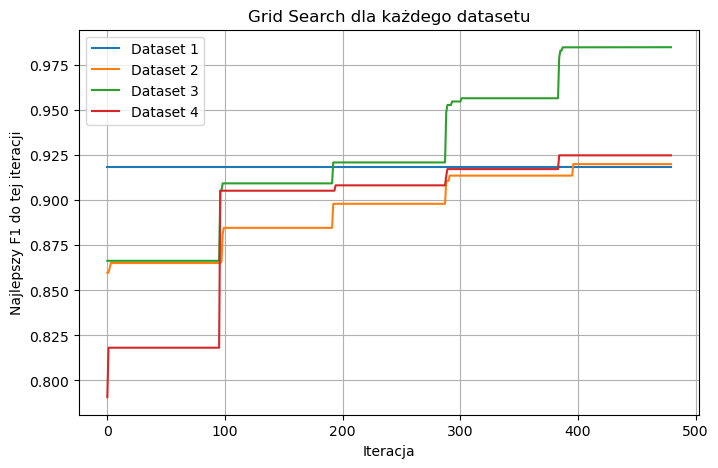

In [ ]:
# 1. Grid search

param_grid = {
    'rf__n_estimators': [60, 100, 140, 180, 220],
    'rf__max_depth': [1, 3, 5, 7, None],
    'rf__min_samples_split': [2, 3, 4, 5],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__max_features': ['sqrt', 'log2']
}



best_f1_grid = [0 for _ in range(4)]
best_params_grid = [None for _ in range(4)]
f1_progress_grid = [[] for _ in range(4)]

default_mean_grid = []
f1_best_global_grid = 0

for params in ParameterGrid(param_grid):
    f1_scores = []

    for name, df in datasets.items():
        X_train, X_test, y_train, y_test = prepare_data(df)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
        ])

        pipe.set_params(**params)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        f1_scores.append(f1_score(y_test, y_pred))

    for i in range(4):
        if f1_scores[i] > best_f1_grid[i]:
            best_f1_grid[i] = f1_scores[i]
            best_params_grid[i] = params
        f1_progress_grid[i].append(best_f1_grid[i])

    avg_f1 = np.mean(f1_scores)
    default_mean_grid.append((avg_f1, params))

    if avg_f1 > f1_best_global_grid:
        f1_best_global_grid = avg_f1

default_f1_grid, default_grid = max(default_mean_grid, key=lambda x: x[0])
print("Najlepsze parametry:", default_grid)
print("Najlepszy średni F1 score:", default_f1_grid)

plt.figure(figsize=(8, 5))

for i in range(4):
    plt.plot(f1_progress_grid[i], label=f"Dataset {i+1}")

plt.xlabel("Iteracja")
plt.ylabel("Najlepszy F1 do tej iteracji")
plt.title("Grid Search dla każdego datasetu")
plt.legend()
plt.grid(True)
plt.show()


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To 

Najlepsze parametry: {'rf__n_estimators': 92, 'rf__max_depth': 7, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt'}
Najlepszy średni F1 score: 0.9347691771815587


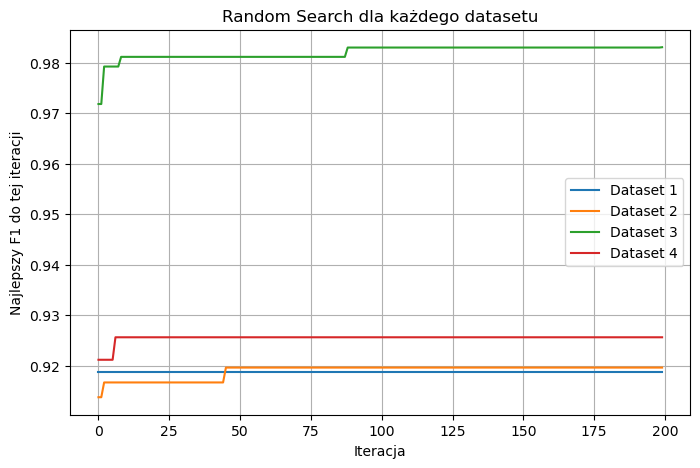

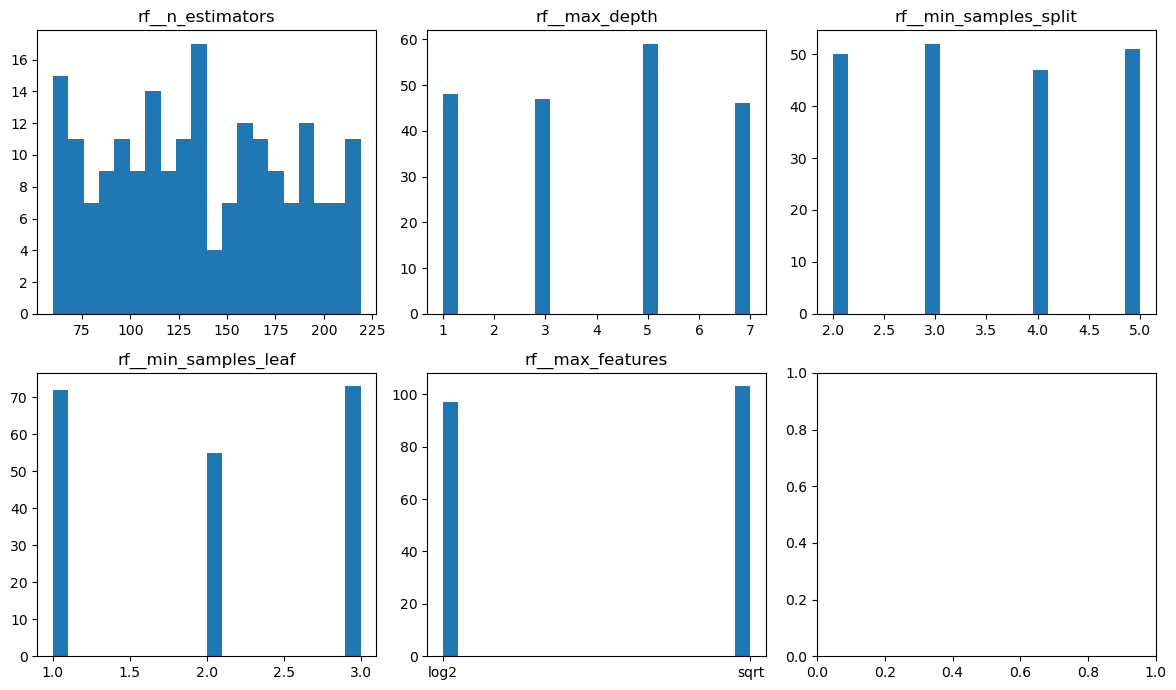

In [46]:
n_iter = 200

best_params_random = [None for _ in range(4)]
best_f1_random = [0 for _ in range(4)]
f1_progress_random = [[] for _ in range(4)]

default_mean_random = []
f1_best_global_random = 0

sampled_params = {
    'rf__n_estimators': [],
    'rf__max_depth': [],
    'rf__min_samples_split': [],
    'rf__min_samples_leaf': [],
    'rf__max_features': []
}

for _ in range(n_iter): 
    f1_scores = []

    combination = {
        'rf__n_estimators': random.randint(60, 220),
        'rf__max_depth': random.choice([1, 3, 5, 7]),
        'rf__min_samples_split': random.randint(2, 5),
        'rf__min_samples_leaf': random.choice([1, 2, 3]),
        'rf__max_features': random.choice(['sqrt', 'log2'])
    }

    for key in combination:
        sampled_params[key].append(combination[key])

    for name, df in datasets.items():
        X_train, X_test, y_train, y_test = prepare_data(df)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
        ])

        pipe.set_params(**combination)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        f1 = f1_score(y_test, y_pred)
        f1_scores.append(f1)

    for i in range(4):
        if f1_scores[i] > best_f1_random[i]:
            best_f1_random[i] = f1_scores[i]
            best_params_random[i] = combination
        f1_progress_random[i].append(best_f1_random[i])

    f1_avg = np.mean(f1_scores)
    default_mean_random.append((f1_avg, combination))

    if f1_avg > f1_best_global_random:
        f1_best_global_random = f1_avg

default_f1_random, default_random = max(default_mean_random, key=lambda x: x[0])

print("Najlepsze parametry:", default_random)
print("Najlepszy średni F1 score:", default_f1_random)

plt.figure(figsize=(8, 5))

for i in range(4):
    plt.plot(f1_progress_random[i], label=f"Dataset {i+1}")

plt.xlabel("Iteracja")
plt.ylabel("Najlepszy F1 do tej iteracji")
plt.title("Random Search dla każdego datasetu")
plt.legend()
plt.grid(True)
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()

for i, (param, values) in enumerate(sampled_params.items()):
    axes[i].hist(values, bins=20)
    axes[i].set_title(param)

plt.tight_layout()
plt.show()


[I 2025-11-18 14:09:12,460] A new study created in memory with name: RF_Bayesian_Optimization_Personality



Optymalizacja bayesowska dla zbioru 0: Personality


  0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:12,735] Trial 0 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 144, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:12,892] Trial 1 finished with value: 0.9164733178654292 and parameters: {'n_estimators': 74, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:13,077] Trial 2 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 92, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:13,226] Trial 3 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 93, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:13,559] Trial 4 finished with value: 0.9164733178654292 and parameters: {'n_estimators': 173, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:13,876] Trial 5 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 172, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:14,138] Trial 6 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 132, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:14,438] Trial 7 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 142, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:14,778] Trial 8 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 162, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:14,995] Trial 9 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 158, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:15,363] Trial 10 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:15,516] Trial 11 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 107, 'max_depth': 1, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:15,647] Trial 12 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 54, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:15,847] Trial 13 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 109, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:16,013] Trial 14 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 83, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:16,196] Trial 15 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 113, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:16,346] Trial 16 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 59, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:16,566] Trial 17 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 140, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:16,763] Trial 18 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 121, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:16,946] Trial 19 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 95, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:17,329] Trial 20 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 192, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:17,629] Trial 21 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 157, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:17,981] Trial 22 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 180, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:18,264] Trial 23 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 142, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:18,564] Trial 24 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 179, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:18,880] Trial 25 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 152, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:19,131] Trial 26 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 125, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:19,394] Trial 27 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 169, 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:19,544] Trial 28 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 66, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:19,743] Trial 29 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 87, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:19,915] Trial 30 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 75, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:20,181] Trial 31 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 130, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:20,459] Trial 32 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 134, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:20,693] Trial 33 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 99, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:21,011] Trial 34 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 150, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:21,276] Trial 35 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 115, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:21,593] Trial 36 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 166, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:21,859] Trial 37 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 133, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:22,062] Trial 38 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 147, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:22,345] Trial 39 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 173, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:22,509] Trial 40 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 101, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:22,944] Trial 41 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 161, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:23,629] Trial 42 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 187, 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:24,246] Trial 43 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 156, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:24,798] Trial 44 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 141, 'max_depth': 2, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:25,343] Trial 45 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 121, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:25,898] Trial 46 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 162, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:26,779] Trial 47 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 199, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:27,337] Trial 48 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 145, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:27,909] Trial 49 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 135, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:28,760] Trial 50 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 176, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:29,421] Trial 51 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 188, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:30,015] Trial 52 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 184, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:30,827] Trial 53 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 199, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:31,317] Trial 54 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 154, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:32,047] Trial 55 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 193, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:32,684] Trial 56 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 169, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:33,365] Trial 57 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 128, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:33,932] Trial 58 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 119, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:34,457] Trial 59 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 109, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.
[I 2025-11-18 14:09:34,665] Trial 60 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 51, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:35,078] Trial 61 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 107, 'max_depth': 1, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:35,414] Trial 62 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 88, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:35,794] Trial 63 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 73, 'max_depth': 1, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:36,210] Trial 64 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 92, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:36,727] Trial 65 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 148, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:37,306] Trial 66 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 138, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:37,743] Trial 67 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 101, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:38,127] Trial 68 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 115, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:38,831] Trial 69 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 160, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:39,155] Trial 70 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 76, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:39,494] Trial 71 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 51, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:39,851] Trial 72 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 62, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:40,348] Trial 73 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 125, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:40,865] Trial 74 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 167, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:41,227] Trial 75 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 82, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:41,609] Trial 76 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 104, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:42,097] Trial 77 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 143, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:42,503] Trial 78 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 96, 'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:43,114] Trial 79 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 138, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.9187935034802784.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:43,945] Trial 80 finished with value: 0.9189814814814815 and parameters: {'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:44,719] Trial 81 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 174, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:45,492] Trial 82 finished with value: 0.9110070257611241 and parameters: {'n_estimators': 180, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:46,397] Trial 83 finished with value: 0.9097303634232122 and parameters: {'n_estimators': 194, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:47,016] Trial 84 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 152, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:47,887] Trial 85 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 183, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:48,597] Trial 86 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 158, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:49,383] Trial 87 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 166, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:50,151] Trial 88 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 188, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:50,766] Trial 89 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 172, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:51,525] Trial 90 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 164, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:52,068] Trial 91 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 113, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:52,595] Trial 92 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 121, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:53,117] Trial 93 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 132, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:53,634] Trial 94 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 127, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:54,300] Trial 95 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 195, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:54,706] Trial 96 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 111, 'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:55,433] Trial 97 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 177, 'max_depth': 1, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:55,779] Trial 98 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 106, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:56,446] Trial 99 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 184, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:56,823] Trial 100 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 118, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:57,087] Trial 101 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 82, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:57,493] Trial 102 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 89, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:57,866] Trial 103 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 68, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:58,114] Trial 104 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 55, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:58,448] Trial 105 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 94, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:58,961] Trial 106 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 98, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:59,272] Trial 107 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 81, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:09:59,717] Trial 108 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 103, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:00,331] Trial 109 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 137, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:00,928] Trial 110 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 145, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:01,341] Trial 111 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 109, 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:01,854] Trial 112 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 114, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:02,467] Trial 113 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 101, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:02,982] Trial 114 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 118, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:03,650] Trial 115 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 123, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:04,335] Trial 116 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 171, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:04,850] Trial 117 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 130, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:05,250] Trial 118 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 91, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:05,963] Trial 119 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 154, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:06,358] Trial 120 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 70, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:06,694] Trial 121 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 61, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:07,031] Trial 122 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 60, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:07,320] Trial 123 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:07,589] Trial 124 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 55, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:08,464] Trial 125 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:08,817] Trial 126 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 78, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:09,334] Trial 127 finished with value: 0.9164733178654292 and parameters: {'n_estimators': 105, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:09,701] Trial 128 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 65, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:10,129] Trial 129 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 85, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:10,784] Trial 130 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 148, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:11,550] Trial 131 finished with value: 0.9035294117647059 and parameters: {'n_estimators': 143, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:12,218] Trial 132 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 141, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:12,711] Trial 133 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 135, 'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:13,069] Trial 134 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 56, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:13,712] Trial 135 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 189, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:14,234] Trial 136 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 150, 'max_depth': 3, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:14,788] Trial 137 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 109, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:15,295] Trial 138 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 131, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:15,877] Trial 139 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 126, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:16,507] Trial 140 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 180, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:17,014] Trial 141 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 117, 'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:17,567] Trial 142 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 123, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:18,012] Trial 143 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 114, 'max_depth': 4, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:18,555] Trial 144 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 160, 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:19,045] Trial 145 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 110, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:19,729] Trial 146 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 196, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:20,212] Trial 147 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 139, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:10:20,812] Trial 148 finished with value: 0.9177288528389339 and parameters: {'n_estimators': 134, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 80 with value: 0.9189814814814815.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
[I 2025-11-18 14:10:21,242] A new study created in memory with name: RF_Bayesian_Optimization_Heart


[I 2025-11-18 14:10:21,225] Trial 149 finished with value: 0.9187935034802784 and parameters: {'n_estimators': 98, 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 80 with value: 0.9189814814814815.

Optymalizacja bayesowska dla zbioru 1: Heart


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-18 14:10:21,492] Trial 0 finished with value: 0.910828025477707 and parameters: {'n_estimators': 52, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 0.910828025477707.
[I 2025-11-18 14:10:22,102] Trial 1 finished with value: 0.9102564102564102 and parameters: {'n_estimators': 173, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 0 with value: 0.910828025477707.
[I 2025-11-18 14:10:22,479] Trial 2 finished with value: 0.9102564102564102 and parameters: {'n_estimators': 98, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.910828025477707.
[I 2025-11-18 14:10:22,996] Trial 3 finished with value: 0.9131832797427653 and parameters: {'n_estimators': 138, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9131832797427653.
[I 2

[I 2025-11-18 14:11:08,553] A new study created in memory with name: RF_Bayesian_Optimization_Loan


[I 2025-11-18 14:11:08,542] Trial 149 finished with value: 0.9137380191693291 and parameters: {'n_estimators': 117, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.9196141479099679.

Optymalizacja bayesowska dla zbioru 2: Loan


  0%|          | 0/150 [00:00<?, ?it/s]

C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:09,031] Trial 0 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 196, 'max_depth': 18, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.9754253308128544.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:09,303] Trial 1 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 112, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.
[I 2025-11-18 14:11:09,465] Trial 2 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 67, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:09,901] Trial 3 finished with value: 0.9700374531835206 and parameters: {'n_estimators': 200, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:10,333] Trial 4 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 188, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:10,652] Trial 5 finished with value: 0.9128787878787878 and parameters: {'n_estimators': 161, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:10,953] Trial 6 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 117, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:11,181] Trial 7 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 97, 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:11,519] Trial 8 finished with value: 0.9830508474576272 and parameters: {'n_estimators': 142, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.
[I 2025-11-18 14:11:11,719] Trial 9 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 91, 'max_depth': 15, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:11,880] Trial 10 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 55, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:12,203] Trial 11 finished with value: 0.9753320683111955 and parameters: {'n_estimators': 141, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.
[I 2025-11-18 14:11:12,403] Trial 12 finished with value: 0.8617594254937163 and parameters: {'n_estimators': 137, 'max_depth': 1, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:12,788] Trial 13 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 159, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:13,055] Trial 14 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 112, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:13,425] Trial 15 finished with value: 0.9734848484848485 and parameters: {'n_estimators': 158, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:13,653] Trial 16 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 86, 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:13,920] Trial 17 finished with value: 0.9529190207156308 and parameters: {'n_estimators': 130, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:14,298] Trial 18 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 177, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:14,572] Trial 19 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 113, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:14,896] Trial 20 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 142, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:15,116] Trial 21 finished with value: 0.981203007518797 and parameters: {'n_estimators': 93, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.
[I 2025-11-18 14:11:15,315] Trial 22 finished with value: 0.981203007518797 and parameters: {'n_estimators': 78, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:15,546] Trial 23 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 98, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:15,863] Trial 24 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 123, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:16,121] Trial 25 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 104, 'max_depth': 18, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.
[I 2025-11-18 14:11:16,296] Trial 26 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 78, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:16,594] Trial 27 finished with value: 0.981203007518797 and parameters: {'n_estimators': 129, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:17,026] Trial 28 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 105, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:17,821] Trial 29 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 150, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:18,232] Trial 30 finished with value: 0.981203007518797 and parameters: {'n_estimators': 64, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:18,665] Trial 31 finished with value: 0.981203007518797 and parameters: {'n_estimators': 79, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:19,082] Trial 32 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 69, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:19,499] Trial 33 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 67, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:19,968] Trial 34 finished with value: 0.981203007518797 and parameters: {'n_estimators': 65, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:20,309] Trial 35 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 51, 'max_depth': 19, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:21,281] Trial 36 finished with value: 0.9734848484848485 and parameters: {'n_estimators': 178, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:21,808] Trial 37 finished with value: 0.9734848484848485 and parameters: {'n_estimators': 90, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:22,538] Trial 38 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 122, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:23,157] Trial 39 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 108, 'max_depth': 17, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:23,715] Trial 40 finished with value: 0.9719626168224299 and parameters: {'n_estimators': 99, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:24,271] Trial 41 finished with value: 0.981203007518797 and parameters: {'n_estimators': 72, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:24,775] Trial 42 finished with value: 0.981203007518797 and parameters: {'n_estimators': 77, 'max_depth': 13, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:25,209] Trial 43 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 84, 'max_depth': 15, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:25,582] Trial 44 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 57, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:25,902] Trial 45 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 50, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:26,286] Trial 46 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 59, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:26,586] Trial 47 finished with value: 0.981203007518797 and parameters: {'n_estimators': 51, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:26,998] Trial 48 finished with value: 0.981203007518797 and parameters: {'n_estimators': 59, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:27,226] Trial 49 finished with value: 0.8743169398907104 and parameters: {'n_estimators': 59, 'max_depth': 1, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:27,986] Trial 50 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 151, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:28,363] Trial 51 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 71, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:28,865] Trial 52 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 93, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:29,151] Trial 53 finished with value: 0.9830508474576272 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:29,760] Trial 54 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 117, 'max_depth': 13, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:30,436] Trial 55 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 132, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:30,919] Trial 56 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 57, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.9831144465290806.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:31,449] Trial 57 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:31,882] Trial 58 finished with value: 0.981203007518797 and parameters: {'n_estimators': 72, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:32,365] Trial 59 finished with value: 0.9792060491493384 and parameters: {'n_estimators': 85, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:32,786] Trial 60 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 62, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:33,500] Trial 61 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 138, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:33,932] Trial 62 finished with value: 0.981203007518797 and parameters: {'n_estimators': 69, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:34,288] Trial 63 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 56, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:35,113] Trial 64 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 147, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:36,001] Trial 65 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 166, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:36,466] Trial 66 finished with value: 0.9108159392789373 and parameters: {'n_estimators': 93, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:36,893] Trial 67 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 75, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:37,330] Trial 68 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 79, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:37,875] Trial 69 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 88, 'max_depth': 16, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:38,288] Trial 70 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 74, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:38,782] Trial 71 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 82, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:39,186] Trial 72 finished with value: 0.981203007518797 and parameters: {'n_estimators': 62, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:39,708] Trial 73 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 76, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:40,146] Trial 74 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 67, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:40,651] Trial 75 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 81, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:41,040] Trial 76 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 54, 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:41,620] Trial 77 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 101, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:42,237] Trial 78 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 96, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:42,612] Trial 79 finished with value: 0.981203007518797 and parameters: {'n_estimators': 65, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:43,319] Trial 80 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 112, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:43,898] Trial 81 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 75, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:44,426] Trial 82 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:44,799] Trial 83 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 68, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:45,267] Trial 84 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:45,709] Trial 85 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 68, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:46,219] Trial 86 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:46,728] Trial 87 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:47,178] Trial 88 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 70, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:47,700] Trial 89 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:48,166] Trial 90 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 64, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:48,628] Trial 91 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:49,053] Trial 92 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 72, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:49,619] Trial 93 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 81, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:50,097] Trial 94 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 62, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:50,636] Trial 95 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 75, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:51,182] Trial 96 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 66, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:51,604] Trial 97 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:52,105] Trial 98 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 87, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:52,523] Trial 99 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 61, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:52,917] Trial 100 finished with value: 0.9830508474576272 and parameters: {'n_estimators': 53, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:53,434] Trial 101 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 67, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:53,970] Trial 102 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:54,523] Trial 103 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 75, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:55,042] Trial 104 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 79, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:55,436] Trial 105 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 68, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:56,445] Trial 106 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 193, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:56,933] Trial 107 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 73, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:57,445] Trial 108 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 84, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:57,880] Trial 109 finished with value: 0.981203007518797 and parameters: {'n_estimators': 59, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:58,383] Trial 110 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 77, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:58,902] Trial 111 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 82, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:59,387] Trial 112 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 63, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:11:59,819] Trial 113 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 69, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:00,282] Trial 114 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 72, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:00,831] Trial 115 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 81, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:01,221] Trial 116 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 66, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:01,666] Trial 117 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 78, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:02,040] Trial 118 finished with value: 0.981203007518797 and parameters: {'n_estimators': 60, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:02,505] Trial 119 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 90, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:02,897] Trial 120 finished with value: 0.981203007518797 and parameters: {'n_estimators': 56, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:03,304] Trial 121 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 64, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:03,702] Trial 122 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 70, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:04,078] Trial 123 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 73, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:04,481] Trial 124 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 63, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:04,954] Trial 125 finished with value: 0.9754253308128544 and parameters: {'n_estimators': 67, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:05,407] Trial 126 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 75, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:05,850] Trial 127 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 61, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:06,252] Trial 128 finished with value: 0.9792843691148776 and parameters: {'n_estimators': 57, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:06,680] Trial 129 finished with value: 0.9773584905660377 and parameters: {'n_estimators': 70, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:07,238] Trial 130 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 79, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:07,718] Trial 131 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 70, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:08,171] Trial 132 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 66, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:08,638] Trial 133 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 73, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:09,103] Trial 134 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 76, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:09,511] Trial 135 finished with value: 0.9734848484848485 and parameters: {'n_estimators': 68, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:09,870] Trial 136 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 63, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:10,239] Trial 137 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 53, 'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:10,754] Trial 138 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 73, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:11,286] Trial 139 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 82, 'max_depth': 3, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:11,655] Trial 140 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 59, 'max_depth': 17, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:12,157] Trial 141 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 71, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:12,840] Trial 142 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 88, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:13,526] Trial 143 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 85, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:14,079] Trial 144 finished with value: 0.9812734082397003 and parameters: {'n_estimators': 77, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:14,580] Trial 145 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 66, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:15,174] Trial 146 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 80, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:15,690] Trial 147 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 70, 'max_depth': 17, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)


[I 2025-11-18 14:12:16,223] Trial 148 finished with value: 0.9850187265917603 and parameters: {'n_estimators': 75, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.


C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
[I 2025-11-18 14:12:16,662] A new study created in memory with name: RF_Bayesian_Optimization_Machine


[I 2025-11-18 14:12:16,639] Trial 149 finished with value: 0.9831144465290806 and parameters: {'n_estimators': 64, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 57 with value: 0.9850187265917603.

Optymalizacja bayesowska dla zbioru 3: Machine


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-18 14:12:17,173] Trial 0 finished with value: 0.7962962962962963 and parameters: {'n_estimators': 129, 'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7962962962962963.
[I 2025-11-18 14:12:17,714] Trial 1 finished with value: 0.897119341563786 and parameters: {'n_estimators': 176, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 1 with value: 0.897119341563786.
[I 2025-11-18 14:12:18,126] Trial 2 finished with value: 0.9166666666666666 and parameters: {'n_estimators': 146, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.9166666666666666.
[I 2025-11-18 14:12:18,785] Trial 3 finished with value: 0.9205020920502092 and parameters: {'n_estimators': 194, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 3 with value: 0.9205020920502092.
[

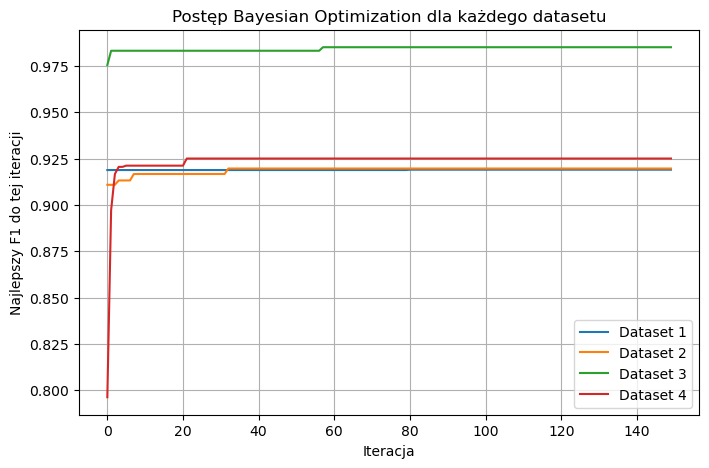


=== Wyniki optymalizacji Bayesowskiej ===

Zbiór 0
Najlepszy F1: 0.9190
Najlepsze parametry: {'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

Zbiór 1
Najlepszy F1: 0.9196
Najlepsze parametry: {'n_estimators': 107, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}

Zbiór 2
Najlepszy F1: 0.9850
Najlepsze parametry: {'n_estimators': 69, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}

Zbiór 3
Najlepszy F1: 0.9250
Najlepsze parametry: {'n_estimators': 179, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [42]:
best_params_bayes = {}
best_f1_bayes = {}
f1_progress_bayes = [[] for _ in range(4)]

def objective_factory(df):
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 1, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
        max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

        X_train, X_test, y_train, y_test = prepare_data(df)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                max_features=max_features,
                random_state=RANDOM_STATE
            ))
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        return f1_score(y_test, y_pred)
    return objective

for i, (name, df) in enumerate(datasets.items()):
    print(f"\nOptymalizacja bayesowska dla zbioru {i}: {name}")
    study = optuna.create_study(direction='maximize', study_name=f"RF_Bayesian_Optimization_{name}")
    study.optimize(objective_factory(df), n_trials=150, show_progress_bar=True)

    best_params_bayes[i] = study.best_params
    best_f1_bayes[i] = study.best_value

    cummax_values = study.trials_dataframe()["value"].cummax()
    f1_progress_bayes[i] = cummax_values.values

plt.figure(figsize=(8, 5))
for i in range(4):
    plt.plot(f1_progress_bayes[i], label=f"Dataset {i+1}")

plt.xlabel("Iteracja")
plt.ylabel("Najlepszy F1 do tej iteracji")
plt.title("Postęp Bayesian Optimization dla każdego datasetu")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Wyniki optymalizacji Bayesowskiej ===")
for i in best_params_bayes.keys():
    print(f"\nZbiór {i}")
    print(f"Najlepszy F1: {best_f1_bayes[i]:.4f}")
    print(f"Najlepsze parametry: {best_params_bayes[i]}")


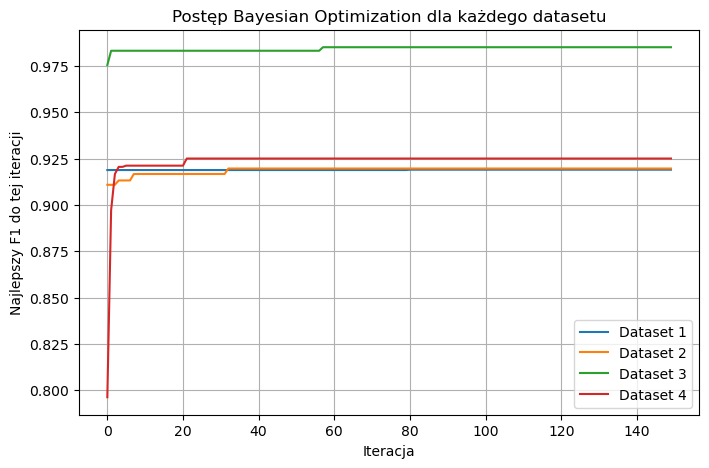


=== Wyniki optymalizacji Bayesowskiej ===

Zbiór 0
Najlepszy F1: 0.9190
Najlepsze parametry: {'n_estimators': 180, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}

Zbiór 1
Najlepszy F1: 0.9196
Najlepsze parametry: {'n_estimators': 107, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}

Zbiór 2
Najlepszy F1: 0.9850
Najlepsze parametry: {'n_estimators': 69, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}

Zbiór 3
Najlepszy F1: 0.9250
Najlepsze parametry: {'n_estimators': 179, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [43]:
plt.figure(figsize=(8, 5))
for i in range(4):
    plt.plot(f1_progress_bayes[i], label=f"Dataset {i+1}")

plt.xlabel("Iteracja")
plt.ylabel("Najlepszy F1 do tej iteracji")
plt.title("Postęp Bayesian Optimization dla każdego datasetu")
plt.legend()
plt.grid(True)
plt.show()

print("\n=== Wyniki optymalizacji Bayesowskiej ===")
for i in best_params_bayes.keys():
    print(f"\nZbiór {i}")
    print(f"Najlepszy F1: {best_f1_bayes[i]:.4f}")
    print(f"Najlepsze parametry: {best_params_bayes[i]}")


In [ ]:
baseline_f1 = []
for name, df in datasets.items():


        X_train, X_test, y_train, y_test = prepare_data(df)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        f1 = f1_score(y_pred, y_test)
        baseline_f1.append(f1)

    

### PORÓWNANIE WYNIKÓW

In [48]:
default_f1_grid_table = []
default_f1_random_table = []

for name, df in datasets.items():
        X_train, X_test, y_train, y_test = prepare_data(df)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
        ])
        
        pipe.set_params(**default_grid)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        default_f1_grid_table.append(f1)

for name, df in datasets.items():
        X_train, X_test, y_train, y_test = prepare_data(df)

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
        ])
        
        pipe.set_params(**default_random)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        default_f1_random_table.append(f1)

grid_diff_pct = [((best - default) / default) * 100 for default, best in zip(default_f1_grid_table, best_f1_grid)]
random_diff_pct = [((best - default) / default) * 100 for default, best in zip(default_f1_random_table, best_f1_random)]
bayes_vs_random_pct = [((bayes - random) / random) * 100 for bayes, random in zip(list(best_f1_bayes.values()), default_f1_random_table)]

wyniki = pd.DataFrame({
    "Grid search domyślny": default_f1_grid_table,
    "Grid search - najlepszy": best_f1_grid,
    "Różnica Grid [%]": grid_diff_pct,
    "Random search domyślny": default_f1_random_table,
    "Random search - najlepszy": best_f1_random,
    "Różnica Random [%]": random_diff_pct,
    "Bayes": list(best_f1_bayes.values()),
    "Różnica Bayes vs Random [%]": bayes_vs_random_pct,
    "Baseline": baseline_f1
})

print(wyniki)

C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(binary_map)
C:\Users\eliss\AppData\Local\Temp\ipykernel_16608\4048281700.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To 

   Grid search domyślny  Grid search - najlepszy  Różnica Grid [%]  \
0              0.916473                 0.918794          0.253165   
1              0.919614                 0.920128          0.055855   
2              0.983114                 0.985019          0.193699   
3              0.912134                 0.925000          1.410550   

   Random search domyślny  Random search - najlepszy  Różnica Random [%]  \
0                0.918794                   0.918794            0.000000   
1                0.916667                   0.919614            0.321543   
2                0.983114                   0.983114            0.000000   
3                0.920502                   0.925620            0.555973   

      Bayes  Różnica Bayes vs Random [%]  Baseline  
0  0.918981                     0.020459  0.899061  
1  0.919614                     0.321543  0.913183  
2  0.985019                     0.193699  0.983114  
3  0.925000                     0.488636  0.925000  
